<a href="https://colab.research.google.com/github/muyuanzhang14/DL_project1/blob/main/DL_Project1_ResNet_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ResNet for CIFAR 10 classfication

In this notebook, we will build a modified residual network (ResNet) architecture with the highest test accuracy on a held-out portion of a version of the CIFAR-10 image classficiation dataset, under the constrain that the model has no more than 5 million parameters.

You are free to experiment around and adjust the parameters to gain boosts in accuracy, as long as the total number of trainable parmeters does not exceed 5 million (You can use the `torchsummary.summary` function to check the number of parameters in your model.)

You are also free to experiemtn with:
- any optimizer (SGD, ADAM, RMSProp, etc)
- any data augmentation strategy
- any regularizer
- any choice of learning rate, batch size, epochs, scheduler, etc.

You are **not** allowed to:
- simply load pre-trained model weights from the web, and fine-tune on the CIFAR-10 You **have** to be able train your model from scratch.
- use other/bigger datasets such as ImageNet.

#### Download Dataset

The dataset we are using is [CIFAR-10 Dataset](https://www.cs.toronto.edu/~kriz/cifar.html) which is labeled subsets of the 80 millions tiny images dataset. CIFAR-10 and CIFAR-100 were created by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. (Sadly, the 80 million tiny images dataset has been thrown into the memory hole by its authors. Spotting the doublethink which was used to justify its erasure is left as an exercise for the reader.)

The CIFAR-10 dataset consists of 60000 ($32 \times 32$) color, images in 10 classes, with 6000 images per class. and there are 50000 training images and 10000 test images.


In [143]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


Since we are using the google coalb, so download and extra dataset first.

In [144]:
!wget -c https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2025-03-14 02:51:48--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [145]:
!tar -xvzf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


#### Import Data

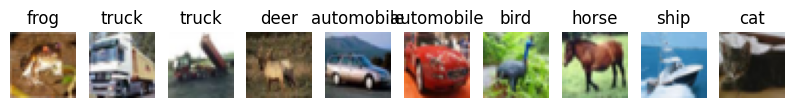

In [146]:
import pickle
import matplotlib.pyplot as plt

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Specify the folder where the CIFAR-10 batch files are
cifar10_dir = 'cifar-10-batches-py'

# Load the label names

meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = [label.decode('utf-8') for label in meta_data_dict[b'label_names']]

# Load one batch for demonstration (data_batch_1)
batch_1_dict = load_cifar_batch(os.path.join(cifar10_dir, 'data_batch_1'))
train_images = batch_1_dict[b'data']
train_labels = batch_1_dict[b'labels']

# Reshape the images
train_images = train_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)

# Display the first 10 images and labels
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_images[i])
    plt.title(label_names[train_labels[i]])  # Decoding from bytes to string
    plt.axis('off')
plt.show()

In [147]:
train_data = []
train_labels = []
for i in range(1, 6):
    batch = load_cifar_batch(os.path.join(cifar10_dir, f'data_batch_{i}'))
    train_data.append(batch[b'data'])
    train_labels += batch[b'labels']

train_data = np.vstack(train_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Convert to HWC format
train_labels = np.array(train_labels)

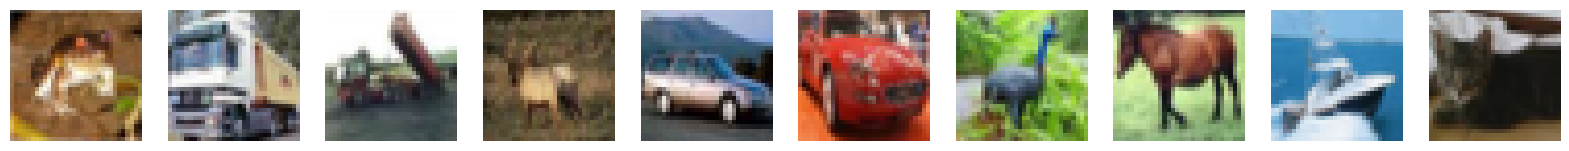

In [148]:
# Display the first 10 images
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_images[i])
    plt.axis('off')
plt.show()

#### Load Dataset

In [149]:
import torch
import torchvision
import torchvision.transforms as transforms

We want to pre-load raw data to calculates the per-channel mean and standard deviation of the CIFAR-10 datasetby iterating through all battches, flattening each image, and accumulating statistics for futher normalization.

In [150]:
from torch.utils.data import DataLoader

# Load dataset without normalization (yet)
transform = transforms.Compose([
    transforms.ToTensor()  # Convert images to PyTorch tensors (values between 0 and 1)
])

# Load CIFAR-10 dataset
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=5000, shuffle=True)  # Large batch size for accurate stats

Files already downloaded and verified


In [151]:
# Function to calculate mean and std
def get_mean_std(dataloader):
    mean = 0.0
    std = 0.0
    total_samples = 0

    for images, _ in dataloader:
        batch_samples = images.size(0)  # Batch size (number of images in batch)
        images = images.view(batch_samples, images.size(1), -1)  # Flatten height & width

        mean += images.mean(dim=[0, 2]) * batch_samples  # Compute mean per channel
        std += images.std(dim=[0, 2]) * batch_samples  # Compute std per channel
        total_samples += batch_samples

    mean /= total_samples
    std /= total_samples

    return mean, std

# Compute mean and std
mean, std = get_mean_std(dataloader)
print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.4914, 0.4822, 0.4465])
Std: tensor([0.2470, 0.2435, 0.2616])


In [152]:
class CustomCIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

As the description, we are allowed to apply data augmentation, regularization.


Base the [Deep Residual Learning for Image Recognition](#https://arxiv.org/pdf/1512.03385), the paper used ImageNet, and the data augmentation strategy that they used  it resized with the image's shorter side randomly sampled in a range for **scale augmentation**. A $224 \times 224$ crop is randomly sampled from image or its **horizontal flip**. The standard **color augmentation** is used.

To pre-processing image data for better accuracy, we used data augmentation, here is the technique that we applyed.
- **PIL convert** `ToPILImage()`: converts a tensor or NumPy array into a PIL image.
- **Random Cropping** `RandomCrop()`: randomly crop out smaller setcion of the image, forcing the model to handle parts of objects or varied backgrounds.
- **Horizontal/Vertical Flipping** `RandomHorizontalFlip()`/: flip an image horizontally with a certain probability. This is teaches the model to be invariant to flips.
- **Color augmentaion** `ColorJitter()`: randomly alter the brightness, contrast, saturation, and hue. This helps the model tolerate differences in lighting and color conditions.
- **ToTensor** `ToTensor()`: convert image or numpy arrays into PyTorch tensors, which makes them usable by PyTorch models. Usually transforms the image from shape (Height, Width, Channel) with values in [0, 255] to shape (Channel, Height, Width) with values in [0, 1]
- **Normalization** `Normalize(mean=[], std=[])`: Subtract the mean and divide by the standard deviation on each channel, usually based on the overall dataset 'statistics. This makes training more stable and faster, normlized inputs help the network learn more effectively.

In [153]:
#pre-processing data
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    #image argumentation
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # color argumentation
    transforms.ColorJitter(
        brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    #Converts [0, 255] to [0, 1]
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])


In [154]:
train_dataset = CustomCIFAR10Dataset(train_data, train_labels, transform=train_transform)

Since test set is to measure model performance on data that simulates "real-world" inputs as closely as possible, we do not add random cropping, flipping, and color jitter which might not reflect real inputs.

In [155]:
# Define transforms for test (only normalization)
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])

In [156]:
batch_test_dict = load_cifar_batch(os.path.join(cifar10_dir, 'test_batch'))
val_images = batch_test_dict[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
val_labels = np.array(batch_test_dict[b'labels'])

In [157]:
val_dataset = CustomCIFAR10Dataset(val_images, val_labels, transform=test_transform)

The paper mentioned that they used **mini-batch** size of **256**. But we will use 128 in for CIFAR-10.

Loads the CIFAR-10 training and test sets with privous transformations, then creates DataLoader objects to feed data in batches to a model duirng training and testing.

In [158]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)

#### Set Up ResNet

Recall that a **residual network (ResNet)** architecture is any convolutional network with skipped connections.

The key component in ResNet model is a residual block that implements:

$$ReLU(S(x) + F(x))$$

where $S(x)$ refers to the skipped connection and $F(x)$ is a block that implements `conv -> BN -> relu -> conv ->BN`; the BN stats for batch normalization. Chaining such blocks layer by layers give a deep ResNet.

Hyperparameters in such architectures incldue:
- $C_i$, the number of channels in the $i$th layer.
- $F_i$, the filter size int the $i$th layer.
- $K_i$, the kernel size of the $i$th skip connection.
- $P$, tghe pool size in the average pool layer.


 ResNet adopts the same $3 \times 3$ convolutional layers design as VGG. In a residual blcok, there are **two** $3 \times 3$ convolutional layers `conv1` and `conv2` with the same number of output channels. Each convolutional layer is followed by a **batch normalization** layer and a **ReLU** activaiton funciton. A **skip connection** then by passes these two convolutional layers to produce outputs that match the input's shape so they can be added. If we need to change the number of channels, we introduce an additional $1 \times 1$ convolution layer `conv3` to transform the input to the required shape before performing the addition ``use_1x1conv``.

 To deal with dimensions increase the projection shortcut is used to match dimensions (which is done by $1 \times 1$ convolutionhs), When the shortcuts go across feature maps of two sizes, they are perfomed with a stride of 2.

In [159]:
from torch import nn, optim
from torch.nn import functional as F

class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

Similar as **GoogLeNet**, the first two layer of the ResNet, after the $3 \times 3$ convolutional layer with 64 output channels and a stride of 2, there is a $3 \times 3$ max pooling layer with a stride of 2.

##### ResNet- 14

In [160]:
b1 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  #3 x 3, 64, stride 2
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))    # 3 x 3 max pooling stride 2

We could add modules, each composed of several residual blocks sharing the same number of output channel. The first module has the same number of channels as the input. Becasue we used a stride-2 max pooling layer earlier, we do not need to reduce the height and width at this stage.

In [161]:
# Subsequent blocks remain the same:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [162]:
b2 = nn.Sequential(*resnet_block(64, 64, 1, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2)) # we can increase the num_residuals to increase the parameters.
b4 = nn.Sequential(*resnet_block(128, 256, 2))
#b5 = nn.Sequential(*resnet_block(256, 512, 1)) #adding b5 will increase to Total params: 11,102,858

In [163]:
net = nn.Sequential(
    b1, b2, b3, b4, #b5,
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(256, 10))

The papaer mention that they used **SGD** with a mini-batch size of **256**, the **learning rate** starts from **0.1** and is divided by 10 when the error plateaus(the model deos not imporve), and the models are trained for up to $60 \times 10^4$, and they used a **weight decay** of **0.0001** and a **momentum** of **0.9**. Also they do not have dropout.

We adopt the experiemnt by setting up the optimizer as SGD with an intial learning rate of 0.1, which is divided by 10 after 20 epochs. we keep the weight decay  at $5e-4$ to prevent overfiting and and momentum values 0.9, respectively. Since this is a classification problem, we use cross-entropy loss as our criterion.

Using step schduler

In [164]:
import torch.optim.lr_scheduler as lr_scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4) # 5e-4 prevent overfitting.
#use scheduler to update the learning rate by 10 after each 10 epoch
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

Using `MultiStepLR()` to update learning rate

In [165]:
# This is for multiStep Learning rate
"""
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[40, 60, 120, 160, 180], gamma=0.1)
    """

'\nscheduler = torch.optim.lr_scheduler.MultiStepLR(\n    optimizer, milestones=[40, 60, 120, 160, 180], gamma=0.1)\n    '

Using `ReduceLROnPlateau()` to uodate learning rate

In [166]:
# if you want to use ReduceLROnPlateau,
# change the scheduler.step() to scheduler.step(test_loss)
# in the training sectiong
"""
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=10, verbose=True)
    """

"\nscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(\n    optimizer, mode='max', factor=0.1, patience=10, verbose=True)\n    "

Now we have the net, we can prints the output shape by passing a random input tensor throug each layers. It visualize how data flows through the networks.

In [167]:
# Create a random input tensor (batch_size=1, channels=3, height=32, width=32)
X = torch.rand(size=(1, 3, 32, 32))
net = net.cpu()
# Forward pass through each layer in the model to see the shape changes
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 16, 16])
Sequential output shape:	 torch.Size([1, 64, 16, 16])
Sequential output shape:	 torch.Size([1, 128, 8, 8])
Sequential output shape:	 torch.Size([1, 256, 4, 4])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 256, 1, 1])
Flatten output shape:	 torch.Size([1, 256])
Linear output shape:	 torch.Size([1, 10])


User `summary()` to visualize each layers and parameters

In [168]:
from torchsummary import summary
# Ensure the model is on the correct device
net = net.to(device)
# Print summary (note: CIFAR-10 has 3 input channels)
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,928
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7           [-1, 64, 16, 16]          36,928
       BatchNorm2d-8           [-1, 64, 16, 16]             128
          Residual-9           [-1, 64, 16, 16]               0
           Conv2d-10            [-1, 128, 8, 8]          73,856
      BatchNorm2d-11            [-1, 128, 8, 8]             256
           Conv2d-12            [-1, 128, 8, 8]         147,584
      BatchNorm2d-13            [-1, 128, 8, 8]             256
           Conv2d-14            [-1, 12

#### Model Training

In [169]:
def train(net, train_loader, test_loader, optimizer, scheduler, criterion, epochs, save_path):
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    lrs = []  # Track learning rate
    best_acc = 0.0  # Track the highest test accuracy

    for epoch in range(epochs):
        net.train()
        train_loss, test_loss = 0.0, 0.0
        train_correct, train_total = 0, 0
        test_correct, test_total = 0, 0

        # ===== TRAIN PHASE =====
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = 100. * train_correct / train_total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # ===== TEST PHASE =====
        net.eval()
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()

        test_loss /= len(test_loader)
        test_acc = 100. * test_correct / test_total
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        # ===== LEARNING RATE SCHEDULER UPDATE =====
        scheduler.step()
        # uncomment it when you need to use ReduceLROnPlateau
        # scheduler.step(test_loss)
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)

        # ===== SAVE BEST MODEL BASED ON TEST ACCURACY =====
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(net.state_dict(), save_path)  # Save the best model
            print(f"Saved Best Model at Epoch {epoch+1} with Test Acc: {best_acc:.2f}%")

        # Print Progress
        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {train_loss:.6f} | Train Acc: {train_acc:.2f}% | "
              f"Test Loss: {test_loss:.6f} | Test Acc: {test_acc:.2f}% | "
              f"LR: {current_lr:.6f}")

    print(f"Training Complete! Best Test Accuracy: {best_acc:.2f}% (Model Saved at {save_path})")
    return train_losses, test_losses, train_accs, test_accs, lrs


def evaluate(net, test_loader, criterion):
    net.eval()
    test_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

In [170]:
n_epochs = 110;
train_losses, test_losses, train_accs, test_accs, lrs = train(net, train_loader, val_loader, optimizer, scheduler, criterion, epochs=n_epochs, save_path="resnet14_best_model.pth")

Saved Best Model at Epoch 1 with Test Acc: 55.83%
Epoch [1/110] | Train Loss: 1.557590 | Train Acc: 42.74% | Test Loss: 1.226695 | Test Acc: 55.83% | LR: 0.100000
Saved Best Model at Epoch 2 with Test Acc: 57.43%
Epoch [2/110] | Train Loss: 1.130761 | Train Acc: 59.65% | Test Loss: 1.284260 | Test Acc: 57.43% | LR: 0.100000
Saved Best Model at Epoch 3 with Test Acc: 64.38%
Epoch [3/110] | Train Loss: 0.925052 | Train Acc: 67.69% | Test Loss: 1.077310 | Test Acc: 64.38% | LR: 0.100000
Saved Best Model at Epoch 4 with Test Acc: 71.66%
Epoch [4/110] | Train Loss: 0.804732 | Train Acc: 72.17% | Test Loss: 0.829026 | Test Acc: 71.66% | LR: 0.100000
Epoch [5/110] | Train Loss: 0.720926 | Train Acc: 74.91% | Test Loss: 0.996185 | Test Acc: 68.30% | LR: 0.100000
Saved Best Model at Epoch 6 with Test Acc: 75.34%
Epoch [6/110] | Train Loss: 0.687407 | Train Acc: 76.57% | Test Loss: 0.700457 | Test Acc: 75.34% | LR: 0.100000
Epoch [7/110] | Train Loss: 0.652074 | Train Acc: 77.72% | Test Loss: 0.

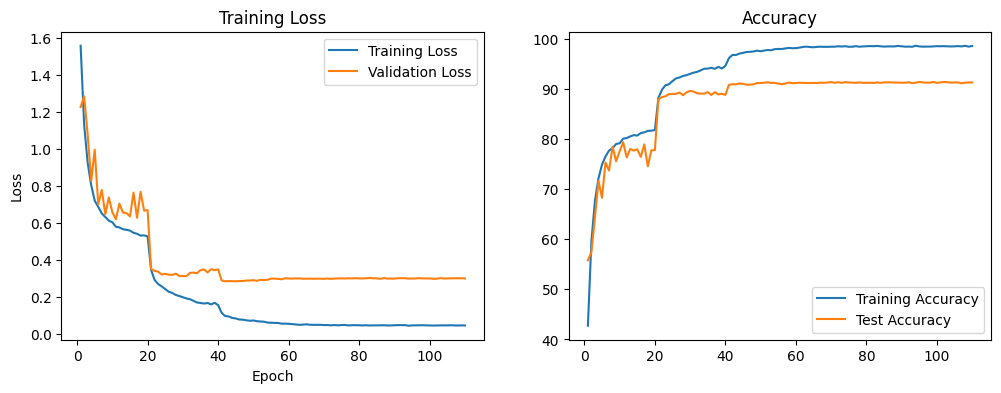

In [177]:
# Plot results
epochs = range(1, n_epochs + 1)
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet-14 Training/Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label='Training Accuracy')
plt.plot(epochs, test_accs, label='Test Accuracy')
plt.legend()
plt.title('ResNet-14 Accuracy')

plt.show()


In [183]:
test_batch = load_cifar_batch('cifar_test_nolabel.pkl')
test_images = test_batch[b'data']

#test_images.shape # check the test shape
# the test dataset do not need PIL
test_transform_2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])

# Convert test dataset to Tensor
test_dataset = [(test_transform_2(img),) for img in test_images]
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = 'resnet14_best_model.pth'
net.load_state_dict(torch.load(model_path, map_location=device))
net.to(device)
net.eval()

predictions = []
with torch.no_grad():
    for batch in test_loader:
        images = batch[0].to(device)  # Get images tensor from tuple and move to device
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

# Generate submission file
submission = pd.DataFrame({'ID': np.arange(len(predictions)), 'Labels': predictions})
submission.to_csv('submission_resnet14_2.csv', index=False)
print("Submission_resnet14 file saved.")

<ipython-input-183-496c37cd985a>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(model_path, map_location=device))


Submission_resnet14 file saved.


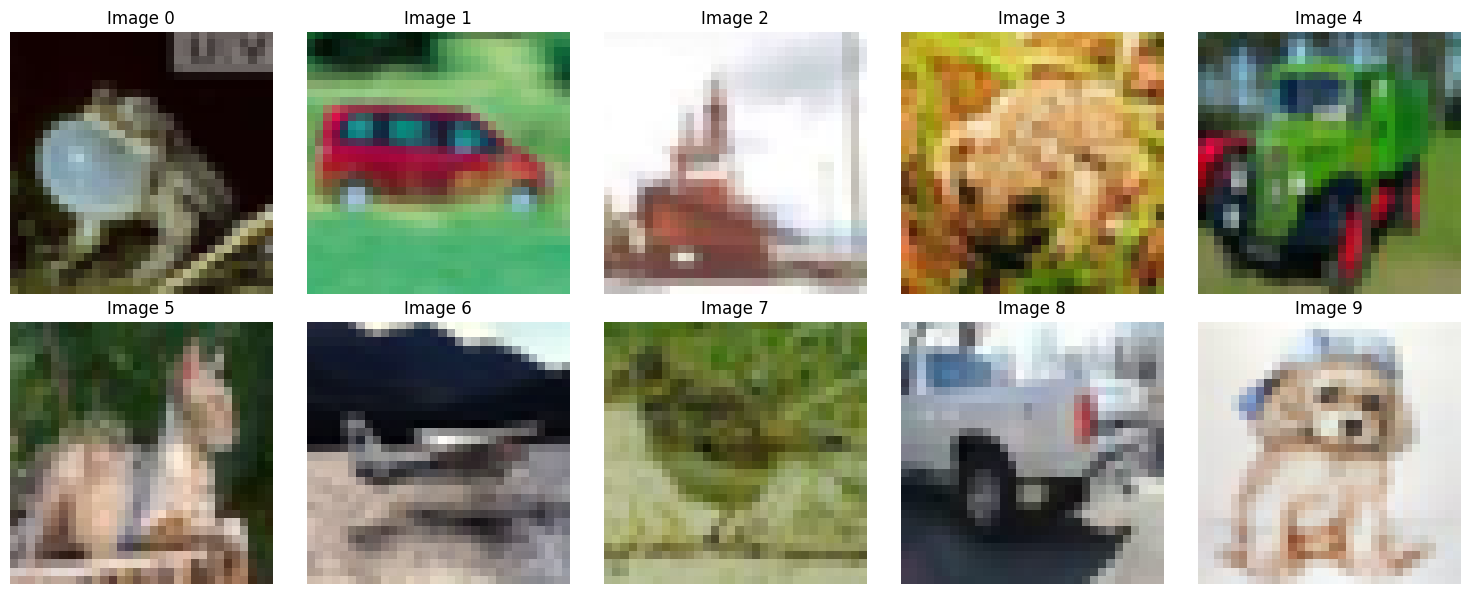

In [181]:
# Load the test dataset
with open('cifar_test_nolabel.pkl', 'rb') as f:
    final_test_data = pickle.load(f)

# Extract images using the byte key b'data'
images = final_test_data[b'data']

# Set up a figure with 2 rows and 5 columns
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Loop over the first 10 images and display each one
for i in range(10):
    img = images[i]
    # Ensure the image is in uint8 format (assuming CIFAR images are stored as 0-255 values)
    ax = axes[i]
    ax.imshow(img.astype(np.uint8))
    ax.set_title(f"Image {i}")
    ax.axis('off')

plt.tight_layout()
plt.show()

#### ReseNet-9

For ResNet-14 we had

Epoch [95/110] | Train Loss: 0.047471 | Train Acc: 98
55% | Test Loss: 0.300832 | Test Acc: 91.44% | LR: 0.000010

Since **ResNet-18** has one more resnet_block with 256 input channels wand 512 output channels, along with two residual connections, adding the last block increases the number of parameters from 2.7 million to 11 million. We are considering how to keep the final 256 to 512 block while reducing the parameter count. The solution is to decrease the number of residual connections in the previous block to keep the total parameters within the 5-million limit.


We keeps the first resnet_block as same, and reduce all the resnet_block, by decreasing the number of residuals to 1, which allows us to add one more resnet_block whihch is (256, 512).

In [184]:
b2_9 = nn.Sequential(*resnet_block(64, 64, 1, first_block=True))
b3_9 = nn.Sequential(*resnet_block(64, 128, 1)) # we can increase the num_residuals to increase the parameters.
b4_9 = nn.Sequential(*resnet_block(128, 256, 1))
b5_9 = nn.Sequential(*resnet_block(256, 512, 1))

In [185]:
net_9 = nn.Sequential(
    b1, b2_9, b3_9, b4_9, b5_9,
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(512, 10))

In [186]:
net_9 = net_9.to(device)
# Print summary (note: CIFAR-10 has 3 input channels)
summary(net_9, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,928
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7           [-1, 64, 16, 16]          36,928
       BatchNorm2d-8           [-1, 64, 16, 16]             128
          Residual-9           [-1, 64, 16, 16]               0
           Conv2d-10            [-1, 128, 8, 8]          73,856
      BatchNorm2d-11            [-1, 128, 8, 8]             256
           Conv2d-12            [-1, 128, 8, 8]         147,584
      BatchNorm2d-13            [-1, 128, 8, 8]             256
           Conv2d-14            [-1, 12

In [187]:
import torch.optim.lr_scheduler as lr_scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net_9 = net_9.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_9.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4) # 5e-4 prevent overfitting.
#use scheduler to update the learning rate by 10 after each 30 epoch
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40, 60, 70, 80, 90], gamma=0.1)

In [82]:
def train(net, train_loader, test_loader, optimizer, scheduler, criterion, epochs, save_path):
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    lrs = []  # Track learning rate
    best_acc = 0.0  # Track the highest test accuracy

    for epoch in range(epochs):
        net.train()
        train_loss, test_loss = 0.0, 0.0
        train_correct, train_total = 0, 0
        test_correct, test_total = 0, 0

        # ===== TRAIN PHASE =====
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = 100. * train_correct / train_total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # ===== TEST PHASE =====
        net.eval()
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()

        test_loss /= len(test_loader)
        test_acc = 100. * test_correct / test_total
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        # ===== LEARNING RATE SCHEDULER UPDATE =====
        scheduler.step()
        # uncomment it when you need to use ReduceLROnPlateau
        # scheduler.step(test_loss)
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)

        # ===== SAVE BEST MODEL BASED ON TEST ACCURACY =====
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(net.state_dict(), save_path)  # Save the best model
            print(f"Saved Best Model at Epoch {epoch+1} with Test Acc: {best_acc:.2f}%")

        # Print Progress
        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {train_loss:.6f} | Train Acc: {train_acc:.2f}% | "
              f"Test Loss: {test_loss:.6f} | Test Acc: {test_acc:.2f}% | "
              f"LR: {current_lr:.6f}")

    print(f"Training Complete! Best Test Accuracy: {best_acc:.2f}% (Model Saved at {save_path})")
    return train_losses, test_losses, train_accs, test_accs, lrs


def evaluate(net, test_loader, criterion):
    net.eval()
    test_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

In [188]:
n_epochs = 100;
train_losses, test_losses, train_accs, test_accs, lrs = train(net_9, train_loader, val_loader, optimizer, scheduler, criterion, epochs=n_epochs, save_path="resnet9_best_model_.pth")

Saved Best Model at Epoch 1 with Test Acc: 60.22%
Epoch [1/100] | Train Loss: 1.407277 | Train Acc: 48.63% | Test Loss: 1.103944 | Test Acc: 60.22% | LR: 0.100000
Saved Best Model at Epoch 2 with Test Acc: 62.57%
Epoch [2/100] | Train Loss: 1.031751 | Train Acc: 63.45% | Test Loss: 1.061791 | Test Acc: 62.57% | LR: 0.100000
Saved Best Model at Epoch 3 with Test Acc: 69.67%
Epoch [3/100] | Train Loss: 0.870513 | Train Acc: 69.71% | Test Loss: 0.880800 | Test Acc: 69.67% | LR: 0.100000
Saved Best Model at Epoch 4 with Test Acc: 71.35%
Epoch [4/100] | Train Loss: 0.771809 | Train Acc: 73.32% | Test Loss: 0.840791 | Test Acc: 71.35% | LR: 0.100000
Saved Best Model at Epoch 5 with Test Acc: 73.59%
Epoch [5/100] | Train Loss: 0.715854 | Train Acc: 75.36% | Test Loss: 0.811243 | Test Acc: 73.59% | LR: 0.100000
Epoch [6/100] | Train Loss: 0.680854 | Train Acc: 76.83% | Test Loss: 0.880202 | Test Acc: 70.91% | LR: 0.100000
Saved Best Model at Epoch 7 with Test Acc: 78.49%
Epoch [7/100] | Train 

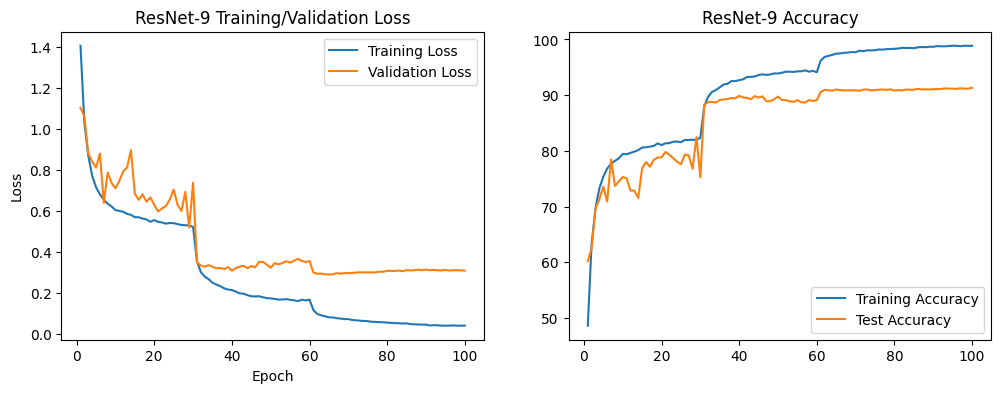

In [192]:
# Plot results
epochs = range(1, n_epochs + 1)
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet-9 Training/Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label='Training Accuracy')
plt.plot(epochs, test_accs, label='Test Accuracy')
plt.legend()
plt.title('ResNet-9 Accuracy')

plt.show()

In [190]:
test_batch = load_cifar_batch('cifar_test_nolabel.pkl')
test_images = test_batch[b'data']#.astype(np.float32) / 255.0

#test_images.shape # check the test shape
# the test dataset do not need PIL
test_transform_2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])

# Convert test dataset to Tensor
test_dataset = [(test_transform_2(img),) for img in test_images]
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = 'resnet9_best_model_2.pth'
net_9.load_state_dict(torch.load(model_path, map_location=device))
net_9.to(device)
net_9.eval()

predictions = []
with torch.no_grad():
    for batch in test_loader:
        images = batch[0].to(device)  # Get images tensor from tuple and move to device
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

# Generate submission file
submission = pd.DataFrame({'ID': np.arange(len(predictions)), 'Labels': predictions})
submission.to_csv('submission_resnet9.csv', index=False)
print("Submission_resnet9 file saved.")

<ipython-input-190-eab88596bc42>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_9.load_state_dict(torch.load(model_path, map_location=device))


Submission_resnet9 file saved.
